<a href="https://colab.research.google.com/github/mr-ayush-agrawal/DL_Notebooks/blob/main/PyTorch/3_MultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Classification
Using Blob Toy Dataset for the task

In [1]:
import torch as pt
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
Num_Classes = 5
Num_Featrues = 2
Random_seed = 42

In [3]:
def acc_fn(y_true, y_pred):
    correct = pt.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_true))*100
    return acc

In [4]:
x_blob, y_blob = make_blobs(n_samples=10000,
                            n_features = Num_Featrues,
                            centers = Num_Classes,
                            random_state = Random_seed)

x_blob = pt.from_numpy(x_blob).type(pt.float)
y_blob = pt.from_numpy(y_blob).type(pt.LongTensor)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_blob, y_blob, test_size=0.2, random_state= Random_seed)

x_train.shape, y_test.shape

(torch.Size([8000, 2]), torch.Size([2000]))

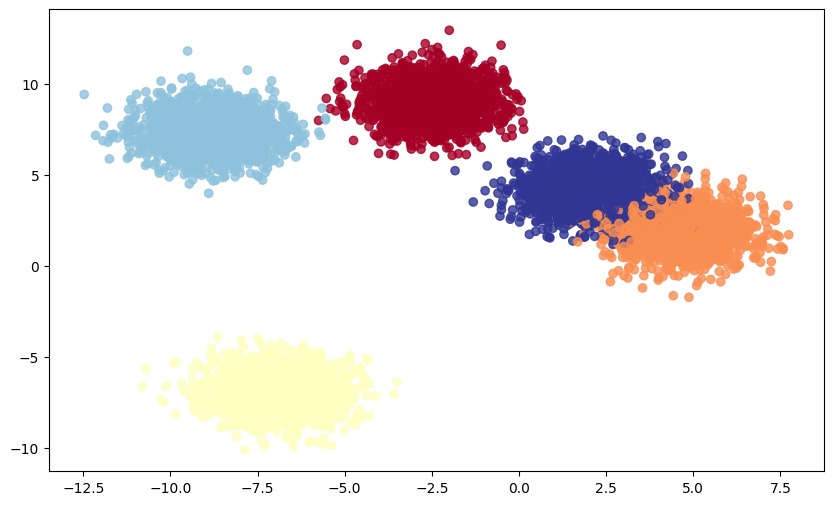

In [6]:
plt.figure(figsize = (10, 6))
plt.scatter(x_train[:, 0], x_train[:, 1], alpha = 0.8, c = y_train, cmap = plt.cm.RdYlBu)

## Building Model

In [7]:
device = 'cuda' if pt.cuda.is_available() else 'cpu'
device

'cpu'

In [8]:
class BlobModel(nn.Module):
    def __init__(self, inp_feat, op_feat, units = 8):
        '''
            Parameter Descriptions
            <Skipping for the time being>
        '''
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=inp_feat, out_features=units),
            nn.ReLU(),
            nn.Linear(in_features=units, out_features=units),
            nn.ReLU(),
            nn.Linear(in_features=units, out_features=op_feat)
        )

    def forward(self, x):
        return self.linear_stack(x)

In [9]:
model = BlobModel(inp_feat=Num_Featrues, op_feat=Num_Classes, units = 16).to(device)
model

BlobModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=5, bias=True)
  )
)

Creating loss function and optimizer

In [10]:
loss_fn = nn.CrossEntropyLoss()

optimizer = pt.optim.SGD(params = model.parameters(),
                         lr = 0.2)


Making the Training Loop

In [11]:
# Getting the predection probabas
model.eval()
with pt.inference_mode():
    y_logits = model(x_test)
y_logits[:10]

tensor([[-1.3053, -0.6048, -0.8169,  0.6870,  0.7171],
        [-1.5587, -0.6819, -1.0599,  0.9252,  0.8426],
        [-0.8947, -0.9203, -0.2388, -0.4077,  0.2468],
        [-0.7826, -0.8695, -0.2374, -0.2796,  0.1576],
        [-0.7038, -0.7449, -0.0581, -0.2752,  0.1527],
        [-1.5571, -0.6873, -1.0455,  0.9125,  0.8497],
        [-0.7634, -0.8622, -0.0322, -0.2475,  0.2080],
        [-0.6518, -1.1498, -0.0697,  0.1660,  0.6427],
        [-0.5532, -0.8505,  0.0265, -0.0162,  0.3147],
        [-0.4639, -0.7836, -0.0591,  0.1262, -0.0826]])

In [12]:
y_test[:10]

tensor([2, 2, 0, 0, 4, 2, 4, 1, 4, 3])

In [13]:
# Need to convert the model logits to prob
y_pred_prob = pt.softmax(y_logits, dim = 1)
y_pred_prob

tensor([[0.0512, 0.1031, 0.0834, 0.3754, 0.3869],
        [0.0356, 0.0856, 0.0587, 0.4270, 0.3931],
        [0.1155, 0.1125, 0.2225, 0.1879, 0.3616],
        ...,
        [0.1180, 0.1099, 0.2144, 0.2003, 0.3574],
        [0.1176, 0.1154, 0.2287, 0.1919, 0.3464],
        [0.1079, 0.1038, 0.2221, 0.1852, 0.3810]])

In [14]:
# Converting the probabs to classes
y_pred = pt.argmax(y_pred_prob, dim = 1)
y_pred

tensor([4, 3, 4,  ..., 4, 4, 4])

Creating Traing loop for model fitting

In [15]:
pt.manual_seed(Random_seed)
pt.manual_seed(Random_seed)

epochs = 100

# putting the data the device
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

In [16]:
%%time
# Looping over for training

for epoch in range(epochs):
    # Trianing
    model.train()

    y_logits = model(x_train)
    y_pred = pt.softmax(y_logits, dim = 1).argmax(dim =1 )

    loss = loss_fn (y_logits, y_train)
    acc = acc_fn(y_pred, y_train)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model.eval()
    with pt.inference_mode():
        test_logits = model(x_test)
        test_pred = pt.softmax(test_logits, dim = 1).argmax(dim = 1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test)

    if epoch % 10==0:
        print(f"epoch: {epoch} | Loss : {loss : .4f} , Acc: {acc: .2f}, test_loss : {test_loss: .4f}, test_acc : {test_acc: .2f}")


epoch: 0 | Loss :  2.0325 , Acc:  38.48, test_loss :  1.3731, test_acc :  52.90
epoch: 10 | Loss :  0.2817 , Acc:  96.85, test_loss :  0.2544, test_acc :  96.75
epoch: 20 | Loss :  0.1404 , Acc:  97.56, test_loss :  0.1372, test_acc :  97.20
epoch: 30 | Loss :  0.0994 , Acc:  97.66, test_loss :  0.1028, test_acc :  97.30
epoch: 40 | Loss :  0.0828 , Acc:  97.66, test_loss :  0.0891, test_acc :  97.30
epoch: 50 | Loss :  0.0745 , Acc:  97.66, test_loss :  0.0824, test_acc :  97.40
epoch: 60 | Loss :  0.0697 , Acc:  97.66, test_loss :  0.0787, test_acc :  97.45
epoch: 70 | Loss :  0.0666 , Acc:  97.67, test_loss :  0.0765, test_acc :  97.45
epoch: 80 | Loss :  0.0645 , Acc:  97.67, test_loss :  0.0750, test_acc :  97.45
epoch: 90 | Loss :  0.0630 , Acc:  97.67, test_loss :  0.0740, test_acc :  97.45
CPU times: user 819 ms, sys: 16.5 ms, total: 836 ms
Wall time: 867 ms


Predecting and evaluating

In [17]:
model.eval()
with pt.inference_mode():
    y_logits = model(x_test)

test_pred = pt.softmax(y_logits, dim = 1).argmax(dim = 1)
test_pred[:10]

tensor([2, 2, 0, 0, 4, 2, 4, 1, 1, 3])

## Evaluating

In [20]:
!pip install torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 16.0 MB/s eta 0:00:00


In [21]:
from torchmetrics import Accuracy

In [24]:
# tcm_acc = Accuracy().to(device)
# tcm_acc(y_pred, y_test)

# Can't get the error -> skipping for the time being will solve later